In [1]:
import math
from typing import Tuple
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

# Make positional encoding
The following class serves as a positional encoding for the input sequence. We need this as attention is permutation invariant.

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self, *, 
        d_model: int,
        dropout: float=0.1,
        max_input_len: int = 5000,

    ):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        position = torch.arange(max_input_len).unsqueeze(1)

        pos_multipliers = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        # input is seq, batch, d_model
        pos_enc = torch.zeros(max_input_len, 1, d_model)

        # evary other value in each sequence element is sine
        pos_enc[:, 0, 0::2] = torch.sin(position * pos_multipliers)
        # the other values are cosine
        pos_enc[:, 0, 1::2] = torch.cos(position * pos_multipliers)

        self.register_buffer('pos_enc', pos_enc)

    def forward(self, x: Tensor):
        x = x + self.pos_enc[:x.size(0)]
        return self.dropout(x)

## Positional encoding exploration
We do some exploration of how the positional encoding works:

In [3]:
a = torch.arange(100).unsqueeze(1)
a.shape

torch.Size([100, 1])

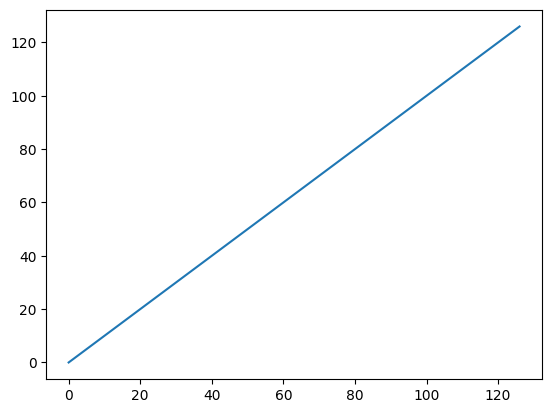

In [4]:
import matplotlib.pyplot as plt
d_model = 128
pos_half =torch.arange(0,d_model, 2) 

plt.plot(pos_half, pos_half)

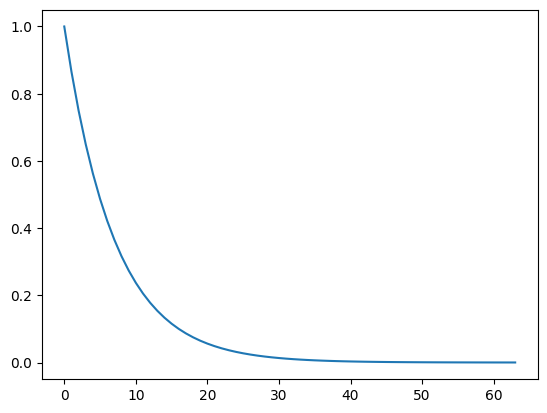

In [5]:

log_div = (-math.log(10000.0) / d_model) * torch.arange(0, d_model, 2) 
# plt.plot(pos_half,log_div)
div_term = torch.exp(log_div)
plt.plot(div_term)


# plt.imshow(log_div, cmap='hot', interpolation='nearest')
# plt.show()

# div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

In [6]:
enc = PositionalEncoding(d_model = 128, dropout = 0, max_input_len=1000)

In [7]:
pos_enc = enc.pos_enc[:, 0, :]
pos_enc.shape

torch.Size([1000, 128])

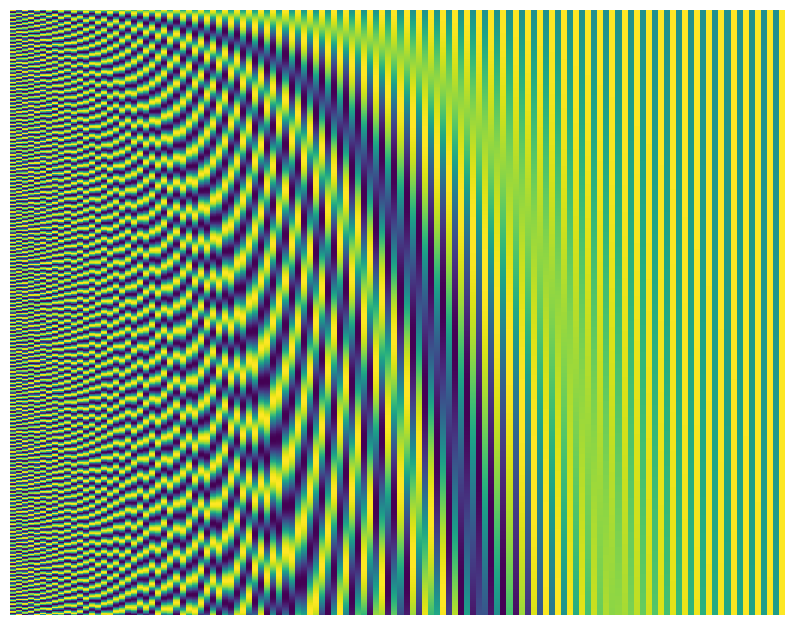

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(pos_enc[:, :], interpolation='nearest')
ax.set_axis_off()
ax.set_aspect(0.1)

# Create the Transformer model

In [3]:
class TransformerModel(nn.Module):
    def __init__(self, *, 
        n_token: int,
        d_model: int,
        n_attn_head: int,
        d_hidden: int,
        n_layers: int,
        dropout: float = 0.5
    ):
        super().__init__()

        self.d_model = d_model

        self.pos_encoder = PositionalEncoding(
            d_model=d_model,
            dropout=dropout,
            max_input_len=5000
        )

        encoder_layer = TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_attn_head,
            dim_feedforward=d_hidden,
            dropout=dropout
        )

        self.transformer_encoder = TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=n_layers
        )

        self.encoder = nn.Embedding(
            n_token, 
            d_model
        )

        # No real decoder - just predict output from encoder output
        # because it is not a seq2seq task
        self.decoder = nn.Linear(d_model, n_token)

        self.init_weights()

    def init_weights(self):
        # just a hyperparameter
        init_range = 0.1 

        self.encoder.weight.data.uniform_(-init_range, init_range)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-init_range, init_range)

    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        """
        src is (seq_len x batch_size) : the tokenized text
        src_mask is (seq_len, seq_len)

        outputs tensor with shape (seq_len, batch_size, ntoken)
        """

        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)

        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output




## Transformer model exploration
I'll explore how the layers in the transformer model work. Before we define the model, let's see how the transformer encoder layers work:

In [10]:
layer = TransformerEncoderLayer(d_model=d_model, nhead=4)
layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (linear1): Linear(in_features=128, out_features=2048, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=2048, out_features=128, bias=True)
  (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

It first applies attention, and then passes through two linear layers. Let's make some fake data and pass it through. It's a batch of 4 sequences, each of length 200.

In [11]:
fake_data = torch.randn((200, 4, d_model))
layer(fake_data).shape

torch.Size([200, 4, 128])

As expected, output shape is the same as input shape. Now let's create a model instance:

In [12]:
net = TransformerModel(
    n_token=1000,
    d_model=128,
    n_attn_head=4,
    d_hidden=256,
    n_layers=4,
    dropout=0
)

net

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0, inplace=False)
        (dropout2): Dropout(p=0, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1

Let's pass the fake data through the transformer encoder:

In [13]:
trans_enc = net.transformer_encoder
out = trans_enc(fake_data)
out.shape

torch.Size([200, 4, 128])

As expected. The encoder is just a stack of encoder layers. Let's now pass that through the decoder:

In [14]:
dec = net.decoder
dec_out = dec(out)
dec_out.shape

torch.Size([200, 4, 1000])

Again, expected results. Instead of the 128 dimension, we now have 1000 outputs for each word. These will be softmaxed to predict the next word. Now let's create a fake token sequence and pass that through some of the layers:

In [15]:
fake_tokens = torch.randint(0, 1000, (200, 4))
fake_tokens.min(), fake_tokens.max()

(tensor(0), tensor(997))

We need a mask to pass through the model. We have not yet explored how the mask works, so we will be using a mask of all zeros.

In [16]:
mask = torch.zeros(200, 200)

Let's pass the data through the model:

In [17]:
out = net(fake_tokens, mask)
out.shape

torch.Size([200, 4, 1000])

Again, makes sense. Let's look at the output at each stage of the model. We begin with the word embedder:

In [19]:
out1 = net.encoder(fake_tokens)
out1.shape

torch.Size([200, 4, 128])

So we have turned out tokens into word embeddings. We next add the positional encoding:

In [20]:
out2 = net.pos_encoder(out1)
out2.shape

torch.Size([200, 4, 128])

Next we pass it through the transformer encoder:

In [21]:
out3 = net.transformer_encoder(out2)
out3.shape

torch.Size([200, 4, 128])

And finally through the decoder:

In [22]:
out_final = net.decoder(out3)
out_final.shape

torch.Size([200, 4, 1000])

# Load and batch data
Now we write code to load and batch data. We need a tokenizer, and a vocabulary builder.

In [4]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

Let's define the data paths

In [5]:
train_path = './data/train.txt'
val_path = './data/valid.txt'
test_path = './data/test.txt'

There might be better ways than this, but it works

In [6]:
def iter_from_file(path):
    with open(path, 'r') as f:
        for line in f:
            yield line

def get_all_iterators():
    train = iter_from_file(train_path)
    val = iter_from_file(val_path)
    test = iter_from_file(test_path)

    return train, val, test


We create the training iterator, and build the vocabulary from it.

In [7]:
train_iter = iter_from_file(train_path)
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

We do a bit of testing:

In [47]:
out = tokenizer("Hello, I'm home darling, bleh, bloblbo")
out

['hello', ',', 'i', "'", 'm', 'home', 'darling', ',', 'bleh', ',', 'bloblbo']

In [50]:
vocab(out)

[3774, 2, 10, 11, 154, 303, 3511, 2, 0, 2, 0]

Cool. We now create a data processor, which turns the text into a single tensor of tokens.

In [8]:
def preprocess_data(raw_text_iterator):

    # each string goes through the tokenizer anc vocabulary. Then turn into a tensor
    data = [
        torch.tensor(vocab(tokenizer(item)), dtype=torch.long)
        for item in raw_text_iterator
    ]

    # concatenate all the tensors that are not empty
    return torch.cat(tuple(filter( lambda t: t.numel() > 0, data)))

Now we create all the datasets:

In [9]:
train_iter, val_iter, test_iter = get_all_iterators()
train_data = preprocess_data(train_iter)
val_data = preprocess_data(val_iter)
test_data = preprocess_data(test_iter)

In [54]:
train_data.shape, val_data.shape, test_iter.shape

(torch.Size([17942100]), torch.Size([1408369]), torch.Size([1653073]))

Pretty long, aren't they?

We now make a batching function. It simply splits the $N$-dimensional dataset into a $N / B \times B$ array, which we can then slice in the sequence dimension to get individual batches. We discard any data that does not fit cleanly into this tensor.

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def batchify(data, batch_size):
    seq_len = data.size(0) // batch_size
    data = data[:seq_len * batch_size]
    data = data.view(batch_size, seq_len).t().contiguous()
    return data.to(device)


Let's explore how the function works.

In [57]:
train_toy = train_data.clone()

In [67]:
batch_size = 64
batched = batchify(train_toy, batch_size)
train_toy.shape, batched.shape, train_toy.shape[0] // batch_size

(torch.Size([17942100]), torch.Size([280345, 64]), 280345)

In [15]:
batched = None

Let's batch all our data:

In [11]:
batch_size = 64
eval_batch_size = 32
train_data = batchify(train_data, batch_size)
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

# Functions to generate input and output sequences
We create a function that fetches the input and the target of a batch:

In [12]:
training_seq_len = 50

In [13]:
def get_batch(source: Tensor, idx: int) :
    seq_len = min(training_seq_len, len(source) - 1 - idx)
    data = source[idx: idx + seq_len]
    target = source[idx + 1:idx + 1 + seq_len].reshape(-1)
    return data, target


A question: why on earth the reshape to a 1d vector?? Let's look at an example output:

In [20]:
X, y = get_batch(train_data[:20, :], 0)
X.shape, y.shape

(torch.Size([19, 64]), torch.Size([1216]))

In [24]:
print(19 * 64)
X[:, 0], y[0::64]

1216


(tensor([  10,   11,  154, 1665,    2, 5125,    5,    7,  157, 4983,    1,   10,
           87,  858,    2,   10,  117,   71,    6]),
 tensor([  11,  154, 1665,    2, 5125,    5,    7,  157, 4983,    1,   10,   87,
          858,    2,   10,  117,   71,    6,  426]))

# Create the model instance

In [14]:
n_tokens = len(vocab)
embedding_dim = 200
d_hidden = 200
n_layers = 2
n_attn_heads = 2
dropout = 0.2

net = TransformerModel(
    n_token=n_tokens,
    d_model=embedding_dim,
    n_attn_head=n_attn_heads,
    d_hidden=d_hidden,
    n_layers=n_layers,
    dropout=dropout
).to(device)

# Train the model

In order to train the model, we need to create an attention mask. This mask prevents the model from incorporating information from future words in the encoding for a word. 

In [ ]:
import copy
import time

loss_fn = nn.CrossEntropyLoss()
lr = 5.0
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1.0, gamma=0.95)

def train(net):
    net.train()
    total_loss = 0.
    log_interval = 200
    start_time = time.time()
    s